In [1]:
import os
import sys

from astropy.io import fits
import astropy.table as at
import astropy.coordinates as coord
import astropy.units as u

import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm
import thejoker as tj
import lightkurve as lk

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

from hq.data import get_rvdata
from hq.samples_analysis import extract_MAP_sample


_path = os.path.abspath('../src/')
if _path not in sys.path:
    sys.path.append(_path)
from data_helpers import prepare_data, sigma_clip_lc
from eclipse_helpers import get_eclipse

thejoker_vac_path = os.path.expanduser('../../apogee-dr16-vac/catalogs/')

In [2]:
kepid = 'KIC 5795648'
apid = '2M19331065+4102072'

In [3]:
allvisit = fits.getdata(os.path.expanduser('~/data/APOGEE_DR16/allVisit-r12-l33.fits'))
tbl = at.QTable(at.Table.read(os.path.join(
    thejoker_vac_path, 'gold_sample.fits')).filled())
row = tbl[tbl['APOGEE_ID'] == apid]

In [4]:
visits = allvisit[allvisit['APOGEE_ID'] == apid]
rv_data = get_rvdata(visits)
rv_data = rv_data[rv_data.rv_err < 10*u.km/u.s]

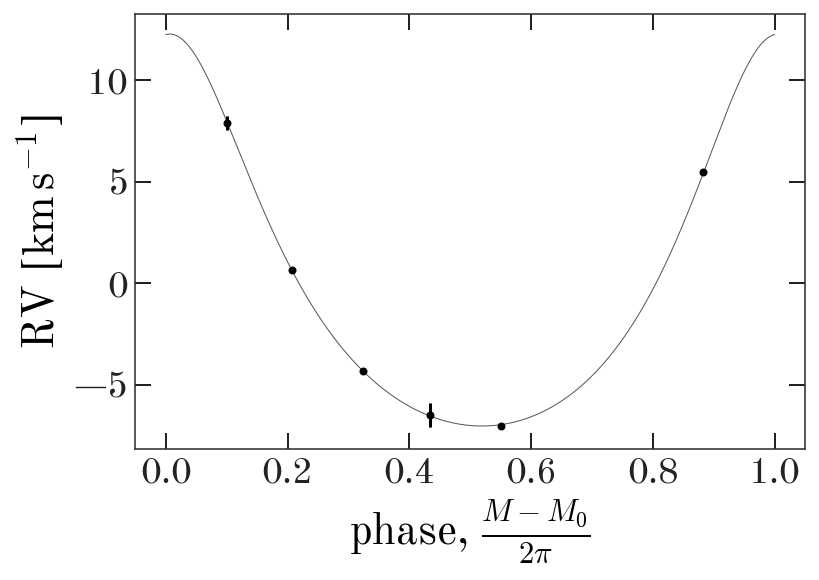

In [5]:
sample = extract_MAP_sample(row)
_ = tj.plot_phase_fold(data=rv_data, sample=sample)

In [6]:
lcfs = lk.search_lightcurvefile(kepid, mission='Kepler').download_all()
stitched_lc = lcfs.PDCSAP_FLUX.stitch()

In [7]:
# From DFM!
with lcfs[0].hdu as hdu:
    tpf_hdr = hdu[1].header
texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0  # days

In [45]:
lc = sigma_clip_lc(stitched_lc[:10000])
raw_data = prepare_data(lc, rv_data)

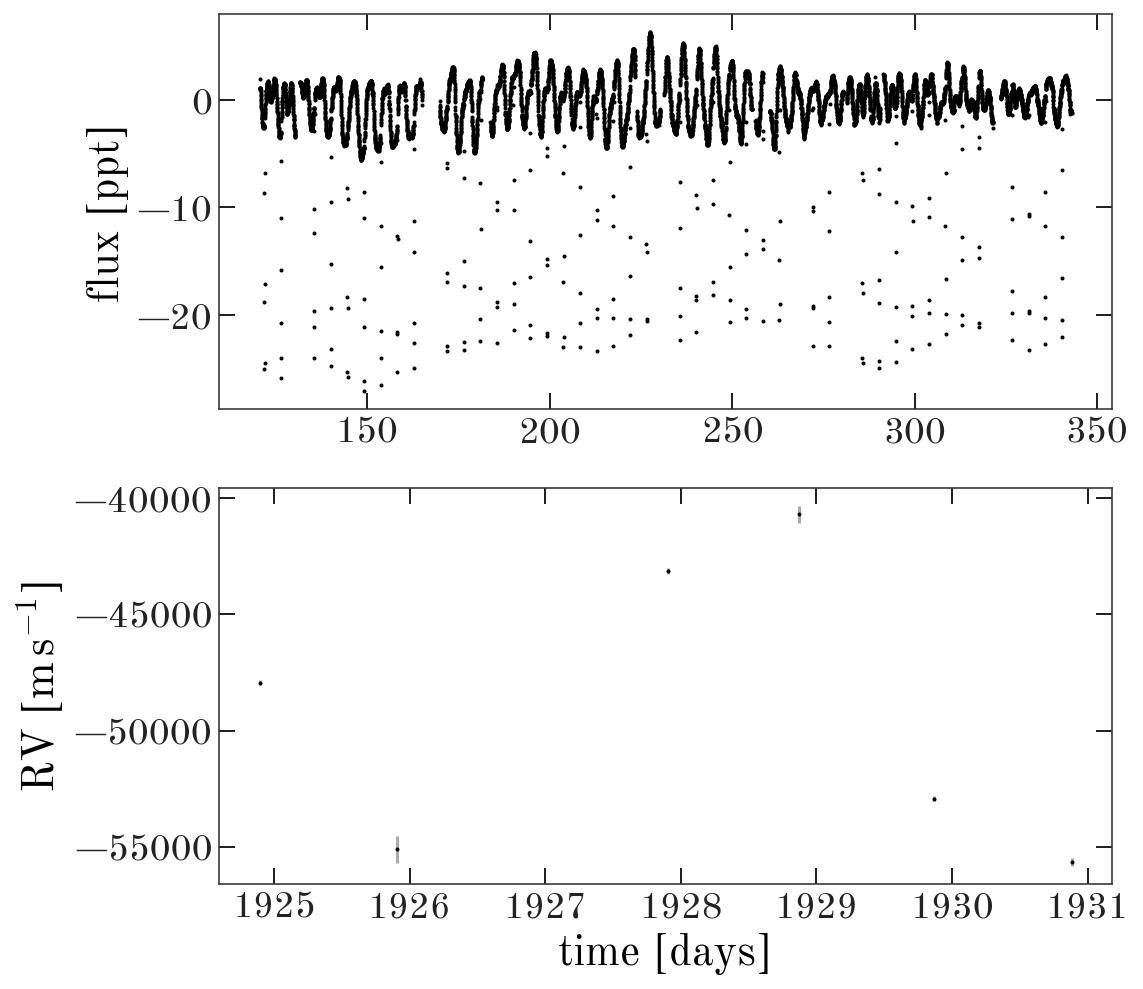

In [46]:
_ = raw_data.plot()

### Eclipses

In [47]:
ecl1, ecl2 = get_eclipse(lc, n_eclipse=2, 
                         P_grid=np.linspace(1, 8, 10000))

In [48]:
ecl1, ecl2

({'period': <Quantity 4.55355536 d>,
  't0': 3.376761256195074,
  'astropy_t0': <Time object: scale='tdb' format='jd' value=2454836.3767612563>,
  'depth_ppt': 18.240539274793214,
  'duration': <Quantity 0.084 d>,
  'eclipse_mask': array([False, False, False, ..., False, False, False])},
 {'period': <Quantity 4.55355536 d>,
  't0': 1.4877059006595097,
  'astropy_t0': <Time object: scale='tdb' format='jd' value=2454834.487705901>,
  'depth_ppt': 2.0803943432167666,
  'duration': <Quantity 1.337 d>,
  'eclipse_mask': array([ True,  True,  True, ...,  True,  True,  True])})

In [49]:
derp = prepare_data(lc=lc)

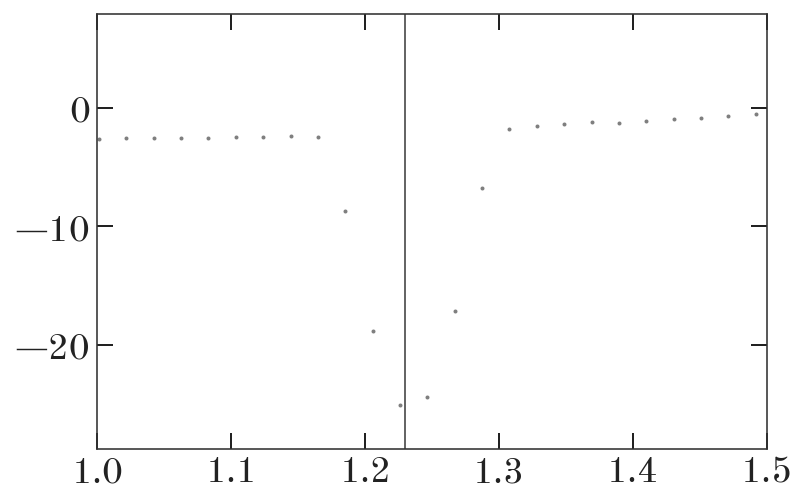

In [50]:
plt.plot(raw_data.flux_t - raw_data.flux_t.min(), # [~ecl1['eclipse_mask']],
         raw_data.flux_ppt, # [~ecl1['eclipse_mask']],
         marker='o', ls='none', ms=2., alpha=0.5)
# plt.xlim(1203, 1204)
plt.xlim(1, 1.5)
for i in range(10, 300):
    plt.axvline(ecl1['t0'] + ecl1['period'].value * i - raw_data.flux_t.min(), marker='', lw=1)

(-0.5, 0.5)

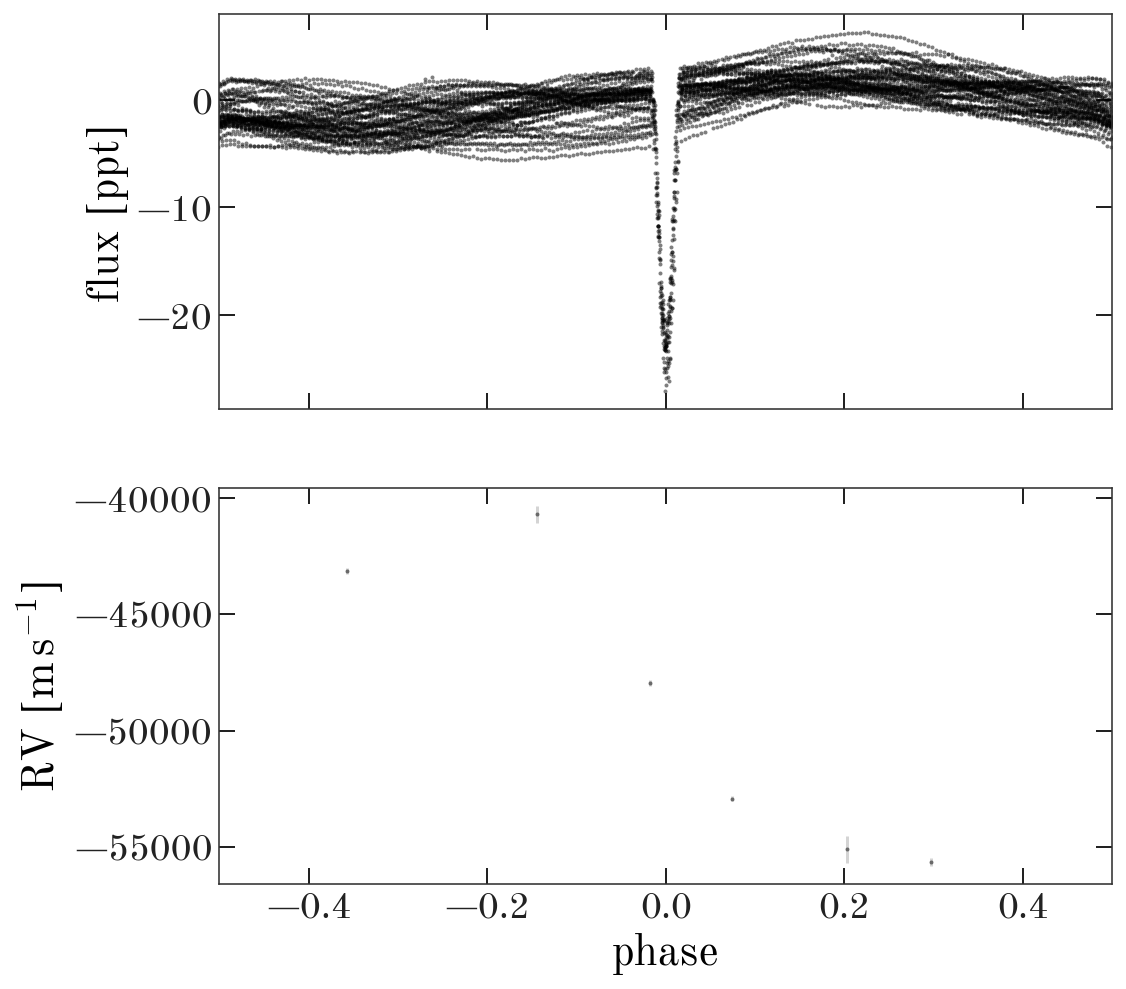

In [51]:
fig = raw_data.plot(P=ecl1['period'].value, 
                    t0=ecl1['t0'], 
                    alpha=0.5)
fig.axes[0].set_xlim(-0.5, 0.5)

### Rotation:

In [52]:
m = ~ecl1['eclipse_mask'] & ~ecl2['eclipse_mask']
results = xo.estimators.lomb_scargle_estimator(
    raw_data.flux_t[m], 
    raw_data.flux_ppt[m], 
    yerr=raw_data.flux_ppt_err[m],
    max_peaks=1, min_period=2.0, max_period=100.0, samples_per_peak=50
)
ls = results["ls"]
peak = results["peaks"][0]

est_rot_period = peak['period']
print(est_rot_period, 
      ls.false_alarm_probability(ls.power(1 / est_rot_period)))

4.525181433147227 0.0


(-0.5, 0.5)

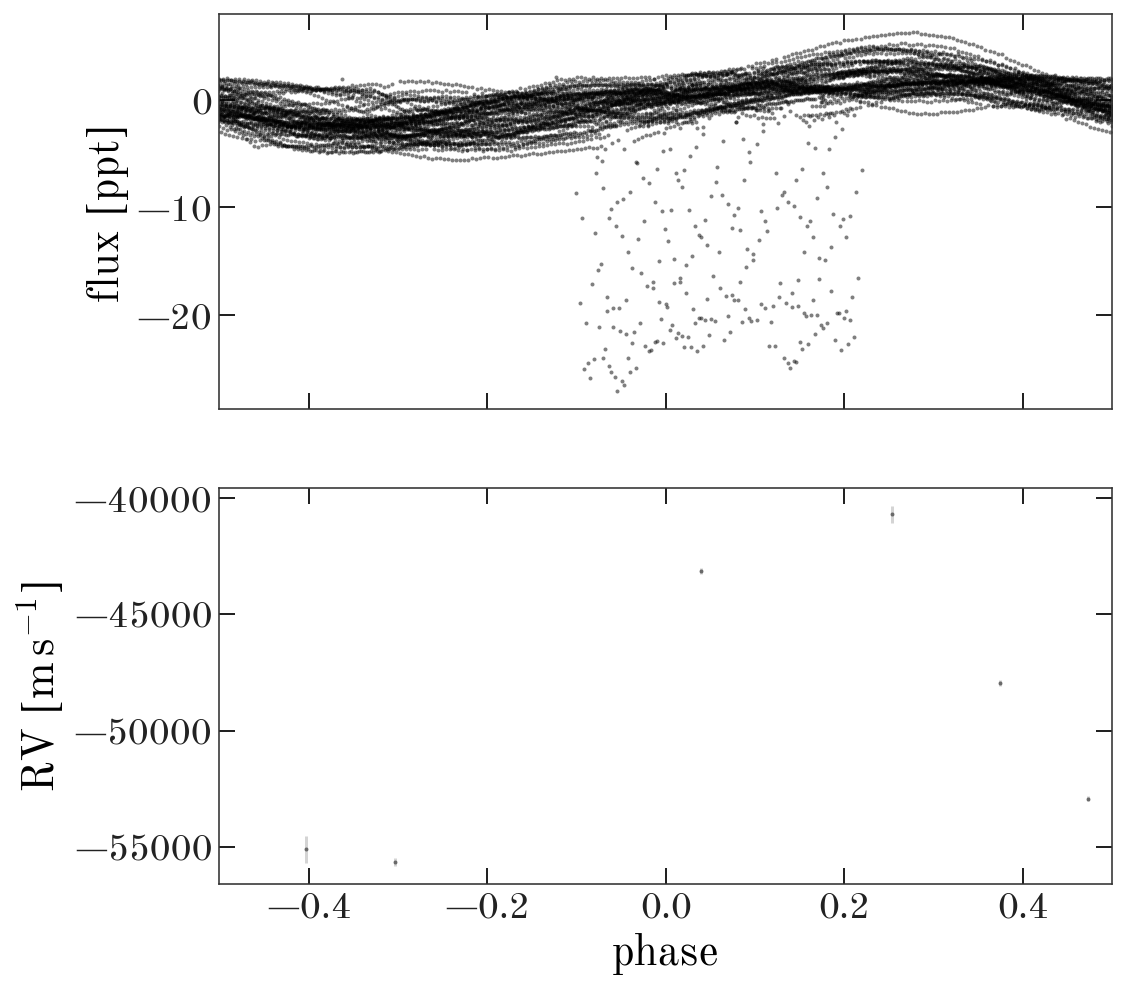

In [53]:
fig = raw_data.plot(P=est_rot_period, 
                    alpha=0.5)
fig.axes[0].set_xlim(-0.5, 0.5)

### Load primary stellar radius and mass from STARHORSE and Gaia:

In [57]:
M_star = row['mass'][0], row['mass_err'][0]
R_star = row['radius_val'][0], row['radius_val'][0] - row['radius_percentile_lower'][0]
M_star, R_star

((1.2241495, 0.1982466), (1.5056379, 0.1897155))

In [58]:
R2 = R_star[0] * np.sqrt(ecl1['depth_ppt']*1e-3)
R2

0.20334774967657593

In [81]:
m2sini = row['m2_min_50'][0].to(u.M_sun)
m2sini, m2sini.to(u.Mjup)

(<Quantity 0.08174266 solMass>, <Quantity 85.6307962 jupiterMass>)

### Expected apsidal precession rate:

https://arxiv.org/pdf/0801.0134.pdf

In [82]:
from astropy.constants import G

In [83]:
R1 = R_star[0] * u.Rsun
M1 = M_star[0] * u.Msun
P = ecl1['period']
Om1 = 2*np.pi / P # assume locked
norbit = 2*np.pi / P

a = np.cbrt(P**2 / (2*np.pi) * G * (M1 + m2sini)).to(u.au)
e = 0.02
q = m2sini / M1

In [88]:
f2 = lambda x: 1 + 1.5*x**2
k21 = 0.01
with u.set_enabled_equivalencies(u.dimensionless_angles()):
    ratio = k21 * (R1 / a)**5 * (15*f2(e)*q + (Om1 / norbit)**2 * (1+q))
    Utidal = P / ratio
    print(Utidal.to(u.yr))

536907.8809236276 yr


Relativistic:

In [87]:
UGR = 1800*(1-e**2) * P.to_value(u.day)**(5/3) * ((M1 + m2sini).to_value(u.Msun))**(-2/3) * u.year
UGR

<Quantity 18839.88512164 yr>

In [91]:
Utot = 1 / (1/UGR + 1/Utidal)
360*u.deg / Utot.to(u.yr)

<Quantity 0.0197789 deg / yr>

---

In [105]:
rv_span = np.max(raw_data.rv_t) - np.min(raw_data.rv_t)
t_rv = np.arange(raw_data.rv_t.min() - rv_span/10, 
                 raw_data.rv_t.max() + rv_span/10, 
                 ecl1['period'].to_value(u.day) / 128)


def build_model(data, phot_mask=None, start=None):
    if phot_mask is None:
        phot_mask = np.ones(len(data.flux_t), dtype=bool)
        
    flux_t = data.flux_t[phot_mask]
    flux_ppt = data.flux_ppt[phot_mask]
    flux_ppt_err = data.flux_ppt_err[phot_mask]
        
    with pm.Model() as model:

        # Parameters for the stellar properties of the primary
        u_star = xo.distributions.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0.5, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Parameters of the companion
        logm = pm.Normal("logm", mu=np.log(m2sini.value), sd=1)  # companion mass
        logr = pm.Normal(
            "logr",
            mu=0.5 * np.log(1e-3 * ecl1['depth_ppt']) + np.log(R_star[0]),
            sd=1,
        )  # companion radius
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        rpl_over_rstar = pm.Deterministic("ror", r_pl / r_star)
        b = xo.distributions.ImpactParameter("b", ror=rpl_over_rstar)
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))  # for tracking
        
        # Parameters of the orbit
        logP = pm.Normal("logP", mu=np.log(ecl1['period'].value), sd=1)
        t0 = pm.Normal("t0", mu=ecl1['t0'], sd=1)
#         ecc = xo.distributions.eccentricity.kipping13(
#             "ecc", long=False, testval=0.05
#         )
#         omega = xo.distributions.Angle("omega")
        sqrte_cosw = pm.Uniform('sqrte_cosw', -1, 1)
        sqrte_sinw = pm.Uniform('sqrte_sinw', -1, 1)
        ecc = sqrte_cosw**2 + sqrte_sinw**2
        omega = tt.arctan2(sqrte_sinw, sqrte_cosw)
        period = pm.Deterministic("period", tt.exp(logP))  # for tracking

        # RV jitter
        # logs_rv = pm.Normal("logs_rv", mu=np.log(100.), sd=0.5)
        # rv0 = pm.Normal("rv0", mu=row['MAP_v0'].to_value(u.m/u.s), sd=500.)  # m/s

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(flux_ppt)), sd=2)
        logw0 = pm.Normal("logw0", mu=0.0, sd=3)
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(flux_ppt)), sd=4)
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(flux_ppt)), sd=5.0)
        BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
        logrotperiod = BoundedNormal("logrotperiod", mu=np.log(est_rot_period), sd=5.0)
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = xo.distributions.UnitUniform("mix")
        rotperiod = pm.Deterministic("rotperiod", tt.exp(logrotperiod))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, m2sini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the transit light curve using starry
        mean_flux = pm.Normal("mean_flux", mu=0.0, sd=10.0)
        transit_light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=flux_t, texp=texp) * 1e3
        
        transit_light_curve = pm.math.sum(transit_light_curves, axis=-1) + mean_flux
        pm.Deterministic("transit_light_curves", transit_light_curves)

        # GP model for the light curve
        # Set up the Gaussian Process model
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
        kernel += xo.gp.terms.RotationTerm(
            log_amp=logamp, period=rotperiod, 
            log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
        )
        gp = xo.gp.GP(kernel, flux_t, 
                      flux_ppt_err**2 + tt.exp(logs2))
        pm.Potential("transit_obs", gp.log_likelihood(flux_ppt - transit_light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(data.rv_t)
        pm.Deterministic("vrad", vrad)

        # The likelihood for the RVs
#         rv_model = pm.Deterministic("rv_model", vrad + rv0)
#         err = tt.sqrt(yerr_rv ** 2 + tt.exp(2 * logs_rv))
#         pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        vrad_pred = orbit.get_radial_velocity(t_rv)
        # pm.Deterministic("rv_model_pred", vrad_pred + rv0)
        pm.Deterministic("rv_model_pred", vrad_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logSw4])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, omega, ecc])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [106]:
model0, map_soln0 = build_model(raw_data)

/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [t0, logP]


/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

optimizing logp for variables: [logs2]


/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -22178.695520816942 -> -16480.460803477243
optimizing logp for variables: [logSw4, logs2]


/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -16480.460803477243 -> -16418.549874478154
optimizing logp for variables: [logw0]


/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -16418.549874478154 -> -16418.3761820768
optimizing logp for variables: [b, logr, r_star]


/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -16418.3761820768 -> -11672.135294396281
optimizing logp for variables: [ecc, omega, t0, logP]


/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

optimizing logp for variables: [mean_flux, mix, logdeltaQ, logQ0, logrotperiod, logamp, logSw4, logw0, logs2, omega, ecc, ecc_beta, ecc_alpha, t0, logP, b, logr, logm, r_star, m_star, u_star]


/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: -11648.576973497651 -> 9603.967978460252


In [108]:
y_fontsize = 12

def plot_light_curve(soln):
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True, sharey=True)

    ax = axes[0]
    ax.plot(raw_data.flux_t, raw_data.flux_ppt, "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean_flux"]
    ax.plot(raw_data.flux_t, gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]", fontsize=y_fontsize)

    ax = axes[1]
    ax.plot(raw_data.flux_t, raw_data.flux_ppt - gp_mod, "k")
    ax.set_ylabel("de-trended flux [ppt]", fontsize=y_fontsize)
    
    ax = axes[2]
    ax.plot(raw_data.flux_t, soln["transit_light_curves"][:, 0], "k")
    ax.set_ylabel("transit [ppt]", fontsize=y_fontsize)

    ax = axes[3]
    mod = gp_mod + soln["transit_light_curves"][:, 0]
    ax.plot(raw_data.flux_t, raw_data.flux_ppt - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]", fontsize=y_fontsize)
    ax.set_xlim(raw_data.flux_t.min(), 
                raw_data.flux_t.max())
    ax.set_xlabel("time [days]")
    
    fig.tight_layout()

    return fig

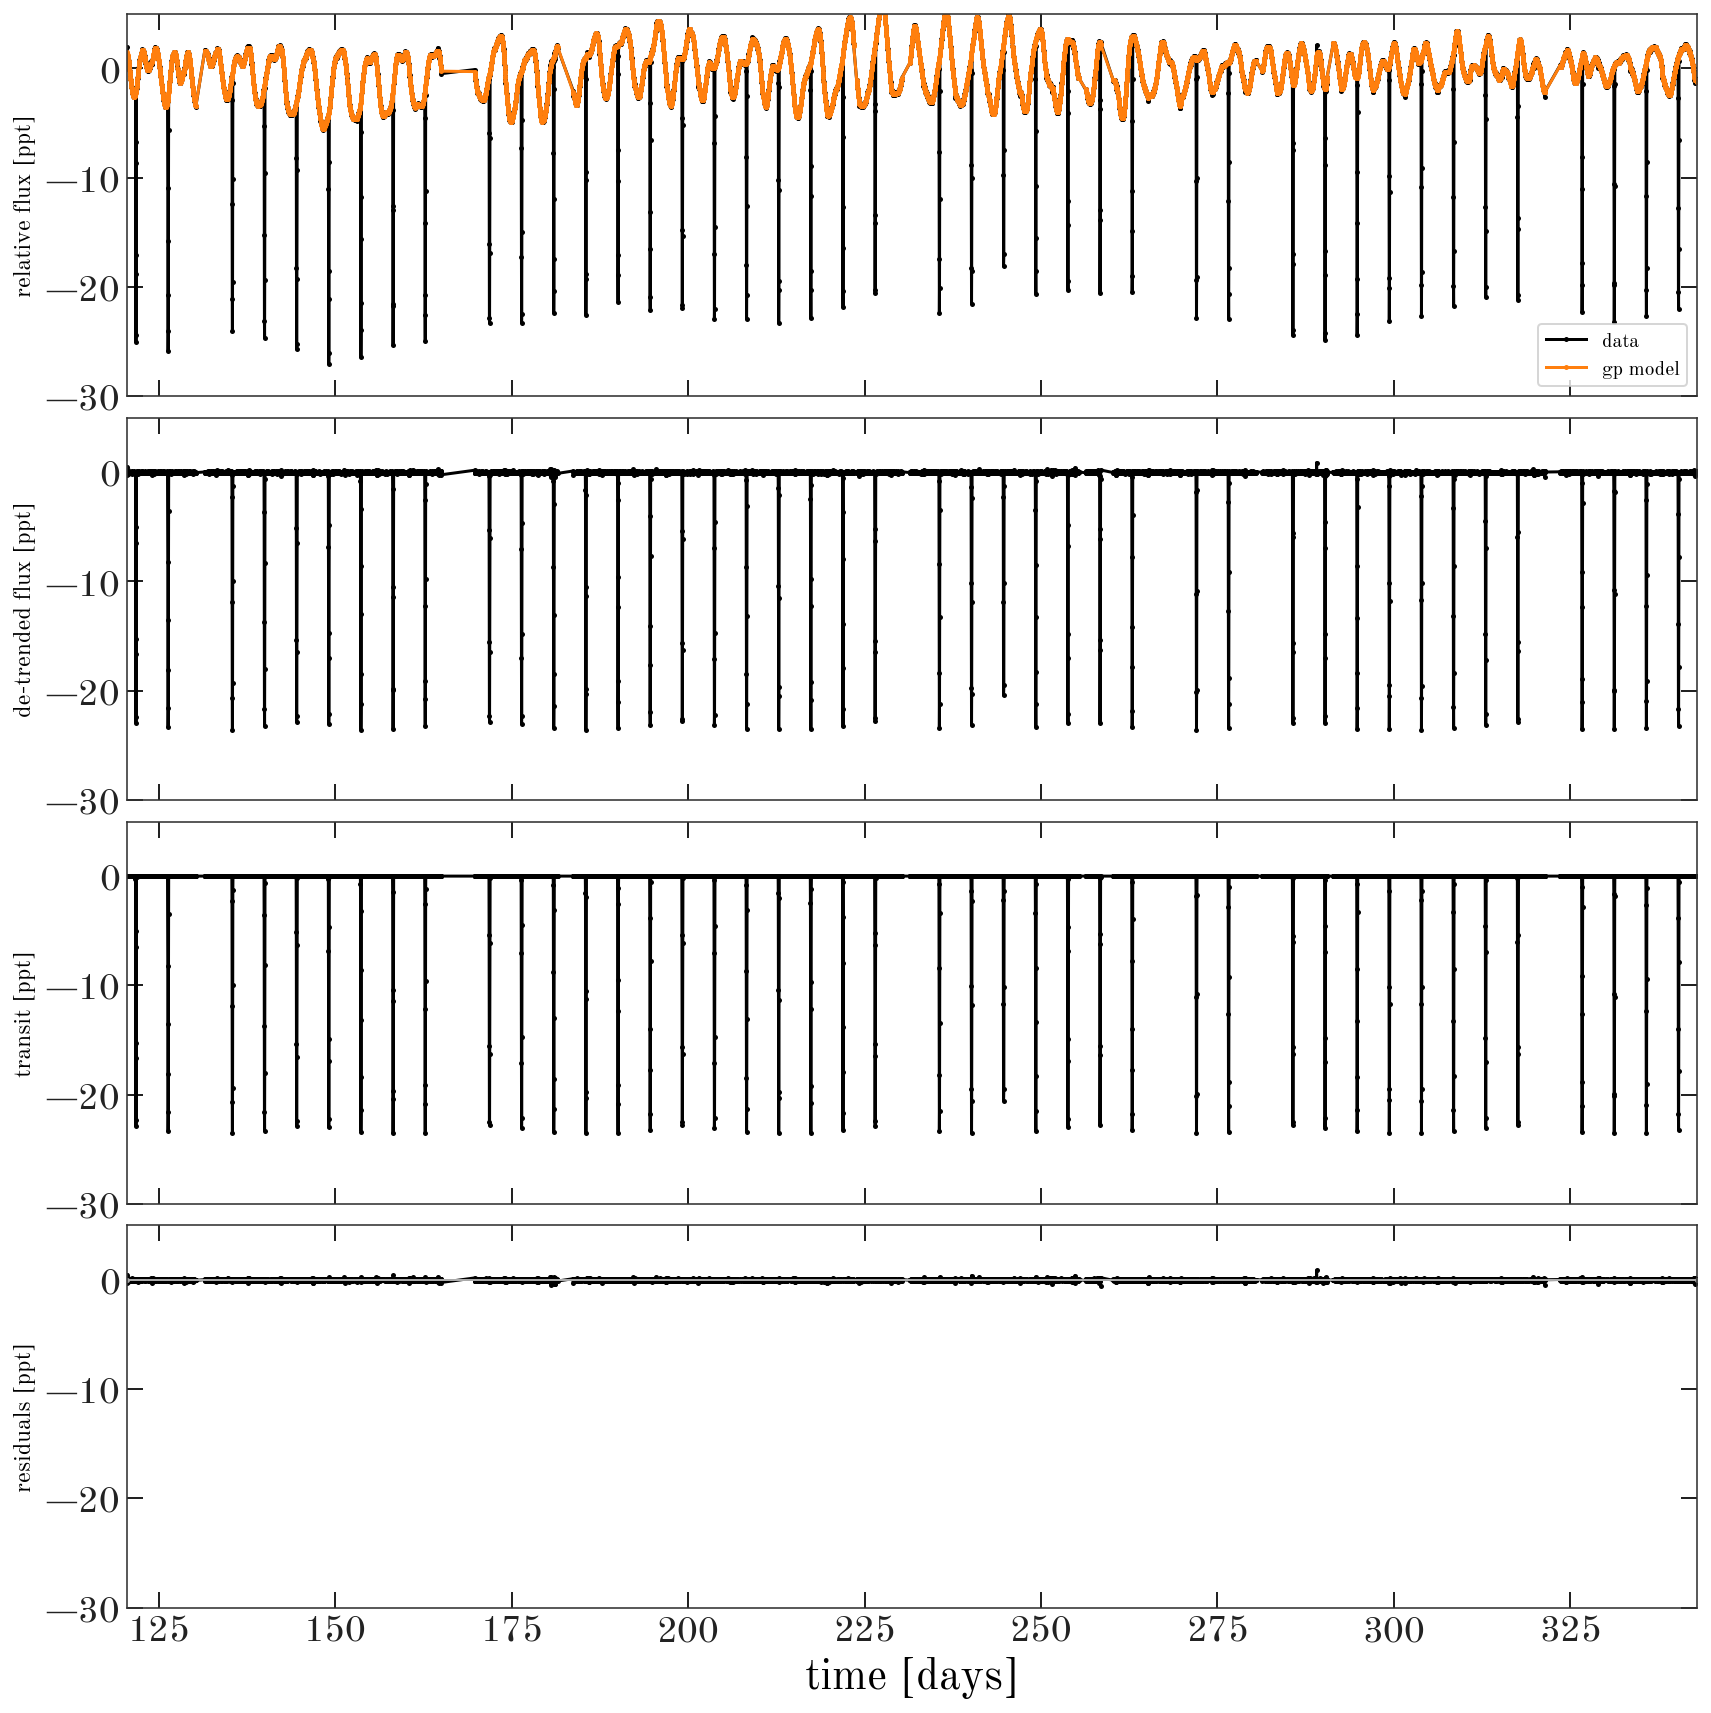

In [114]:
fig = plot_light_curve(map_soln0)
# fig.axes[0].set_xlim(0, 300)
fig.axes[0].set_ylim(-30, 5)
fig.set_facecolor('w')

In [116]:
np.random.seed(123)
with model0:
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=map_soln0,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_flux, mix, logdeltaQ, logQ0, logrotperiod, logamp, logSw4, logw0, logs2, omega, ecc, ecc_beta, ecc_alpha, t0, logP, b, logr, logm, r_star, m_star, u_star]
Sampling 4 chains:  29%|██▉       | 2300/8000 [1:11:54<2:58:13,  1.88s/draws]


ValueError: Not enough samples to build a trace.

---

In [ ]:
def plot_rv_curve(soln):
    err = np.sqrt(yerr_rv ** 2 + np.exp(2 * soln["logs_rv"]))
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 7))

    ax = axes[0]
    ax.errorbar((x_rv/soln['period']) % 1, y_rv, yerr=yerr_rv, 
                marker='o', ls='none', color='k')
    ax.errorbar((x_rv/soln['period']) % 1, y_rv, yerr=err, 
                marker='', ls='none', color='tab:red', zorder=-100)
    ax.plot((t_rv/soln['period']) % 1, soln["vrad_pred"], "--k", alpha=0.5, color='tab:blue')
    ax.plot((t_rv/soln['period']) % 1, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]", fontsize=y_fontsize)
    ax.set_xlim(0, 1)

    ax = axes[1]
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=yerr_rv, 
                marker='o', ls='none', color='k')
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, 
                marker='', ls='none', color='tab:red', zorder=-100)
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]", fontsize=y_fontsize)
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")
    fig.tight_layout()

In [ ]:
plot_rv_curve(map_soln0)

Sigma clip the outliers:

In [ ]:
_mask = sub_mask

mod = (
    map_soln0["gp_pred"]
    + map_soln0["mean_flux"]
    + np.sum(map_soln0["transit_light_curves"], axis=-1)
)
resid = y[_mask] - mod
rms = np.sqrt(np.median(resid ** 2))
mask_iter1 = np.abs(resid) < 10 * rms

plt.plot(x[_mask], resid, "k", label="data")
plt.plot(x[_mask][~mask_iter1], resid[~mask_iter1], "xr", mew=1, label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x[_mask].min(), x[_mask].max());
plt.axhline(7*rms)
plt.axhline(-7*rms)

In [ ]:
tmp_mask = sub_mask.copy()
tmp_mask[:len(mask_iter1)] = mask_iter1
model, map_soln1 = build_model(start=map_soln0, phot_mask=tmp_mask)

In [ ]:
fig = plot_light_curve(map_soln1, tmp_mask);
fig.axes[0].set_xlim(0, 300)
fig.axes[0].set_ylim(-10, 5)
fig.set_facecolor('w')

In [ ]:
plot_rv_curve(map_soln1)

In [ ]:
np.exp(map_soln1['logP'])

In [ ]:
map_soln1['ecc']

In [ ]:
map_soln1['r_pl']

In [ ]:
mass = map_soln1['m_pl'] * u.Msun
mass.to(u.Mjup)

In [ ]:
map_soln1['rotperiod']

---

In [ ]:
np.random.seed(123)
with model:
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=map_soln1,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

In [ ]:
pm.summary(trace, var_names=["period", "r_pl", "m_pl", "ecc", "omega", "b", "rotperiod"])

In [ ]:
print(trace.varnames)

In [ ]:
np.mean((trace['r_pl'] * u.Rsun).to(u.Rjup))

In [ ]:
(np.mean(trace['m_pl'])*u.Msun).to(u.Mjup), (np.std(trace['m_pl'])*u.Msun).to(u.Mjup)

In [ ]:
np.mean((trace['rotperiod'] * u.day))

In [ ]:
np.mean(trace['ecc'])

In [ ]:
np.mean(trace['m_star'])

In [ ]:
plt.figure(figsize=(8, 5))

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x_rv - t0 + 0.5 * p) % p - 0.5 * p
plt.errorbar(x_fold, y_rv, yerr=yerr_rv, fmt=".k", label="data")

# Compute the posterior prediction for the folded RV model for this
# planet
t_fold = (t_rv - t0 + 0.5 * p) % p - 0.5 * p
inds = np.argsort(t_fold)
pred = np.percentile(trace["vrad_pred"][:, inds], [16, 50, 84], axis=0)
plt.plot(t_fold[inds], pred[1], color="C1", label="model", marker='')
art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("phase [days]")
plt.ylabel("radial velocity [m/s]")
# plt.title("K2-24{0}".format(letter));

In [ ]:
plt.figure(figsize=(8, 5))

# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean_flux"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[tmp_mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[tmp_mask] - gp_mod, ".k", label="data", zorder=-1000)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["transit_light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model", marker='')
art = plt.fill_between(
    x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.4f} +/- {1:.4f} d".format(
    np.mean(trace["period"]), np.std(trace["period"])
)

plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
# plt.title("K2-24{0}".format(letter))
plt.xlim(-0.3, 0.3)